In [1]:
import scanpy as sc
import scanorama
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
adata=sc.read_h5ad("I:\\mutiomics\\ICC\\combined\\anndata_combine.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 25959 × 16904
    obs: 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'batch'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'clusters', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
adata.obs['batch']= adata.obs['batch'].astype(str)
adata.obs['clusters']= adata.obs['clusters'].astype(str)

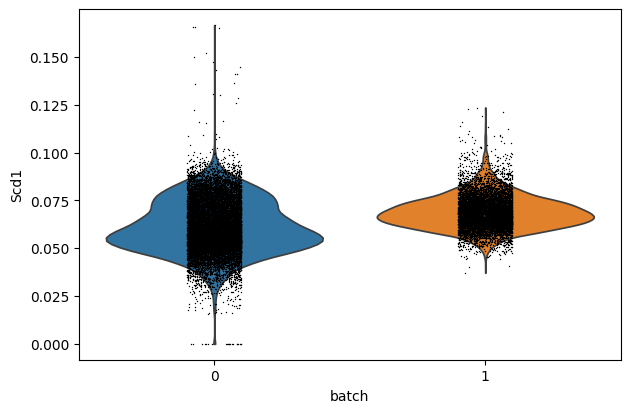

In [53]:

sc.pl.violin(adata, ["Scd1"], groupby='batch')

In [26]:
import seaborn as sns

In [27]:
df = sc.get.obs_df(adata, ['Scd1'])
df = df.set_index('batch').stack().reset_index()
df.columns = ['batch', 'gene', 'value']


KeyError: "None of ['batch'] are in the columns"

In [50]:
df = sc.get.obs_df(adata, ['Scd1',"batch","clusters"])

In [45]:
df = df.set_index('Scd1').stack().reset_index()

In [51]:
df

,Scd1,batch,clusters
0-0,0.082884,0,0
1-0,0.078818,0,0
2-0,0.086254,0,0
3-0,0.070236,0,0
4-0,0.063522,0,0
...,...,...,...
12064-1,0.081692,1,5
12065-1,0.093628,1,7
12066-1,0.089046,1,7
12067-1,0.060760,1,7


<Axes: xlabel='clusters', ylabel='Scd1'>

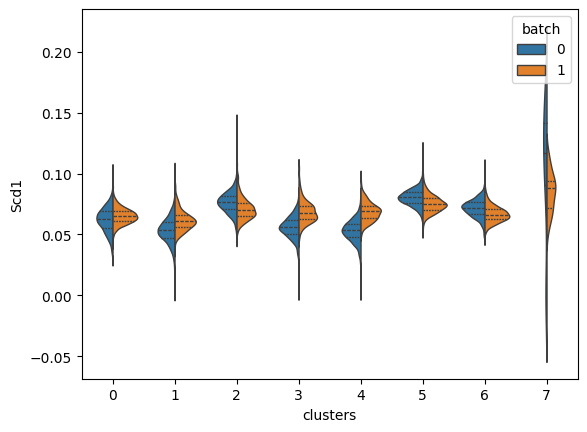

In [52]:
sns.violinplot(data=df, x='clusters', y='Scd1', hue="batch",
                split=True, inner="quart", linewidth=1)   

In [54]:
adata1 = sc.read_h5ad('I:\\mutiomics\\ICC\\KO_merge.h5ad')
adata2 = sc.read_h5ad('I:\\mutiomics\\ICC\\WT_merge.h5ad')

In [61]:
adata1

AnnData object with n_obs × n_vars = 16610 × 18206
    obs: 'b_prime_label', 'a_label'
    uns: 'a_label_colors', 'b_prime_label_colors', 'clusters', 'clusters_colors', 'combine_cluster_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'

In [89]:
adata2.obs["b_prime_label"].astype(int).unique()

array([2, 3, 1, 6, 4, 0, 5, 7, 8])

In [71]:
sc.pl.palettes.default_20
example_dict = {i: key for i, key in enumerate(sc.pl.palettes.default_20)}

example_dict
color_mapping = {i: key for i, key in enumerate(sc.pl.palettes.default_20)}

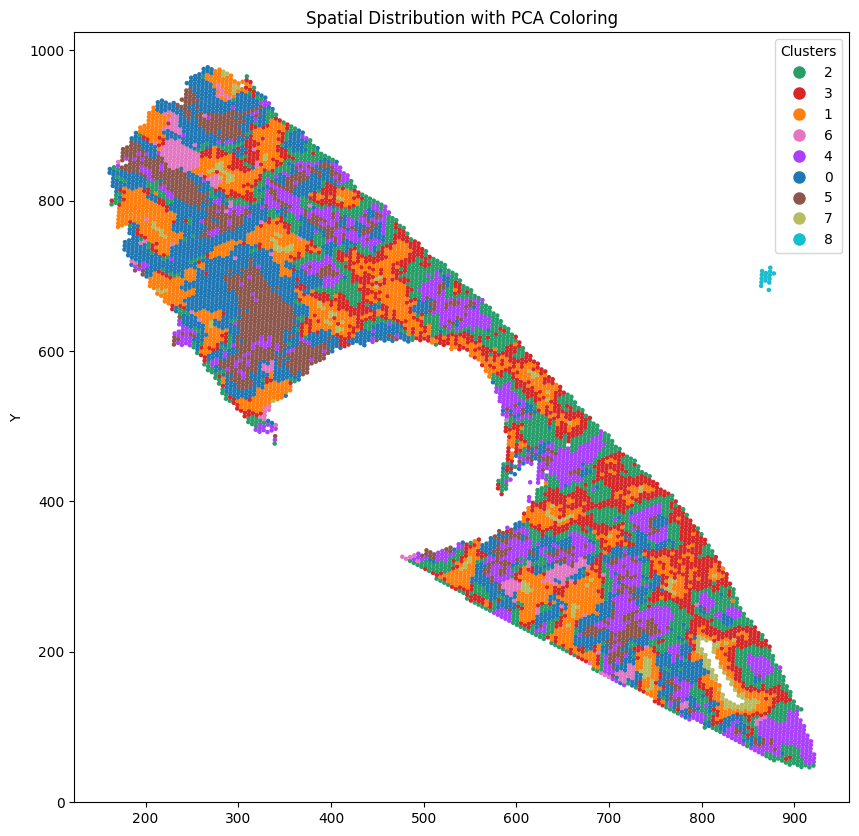

In [78]:
plt.figure(figsize=(10, 10))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in adata2.obs["b_prime_label"].astype(int).tolist()], s=5, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = adata2.obs["b_prime_label"].astype(int).unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Clusters")
plt.show()


In [94]:
df1 = sc.get.obs_df(adata1, ['Scd1',"b_prime_label"])
df1["batch"]="WT"

In [95]:
df2 = sc.get.obs_df(adata2, ['Scd1',"b_prime_label"])
df2["batch"]="KO"

In [96]:
df = pd.concat([df1, df2], axis=0)

In [97]:
df

,Scd1,b_prime_label,batch
0,3.703697,0,WT
1,3.680724,0,WT
2,3.986277,4,WT
3,3.287870,0,WT
4,3.044872,0,WT
...,...,...,...
9344,1.968975,8,KO
9345,2.799357,8,KO
9346,3.167230,8,KO
9347,2.166419,8,KO


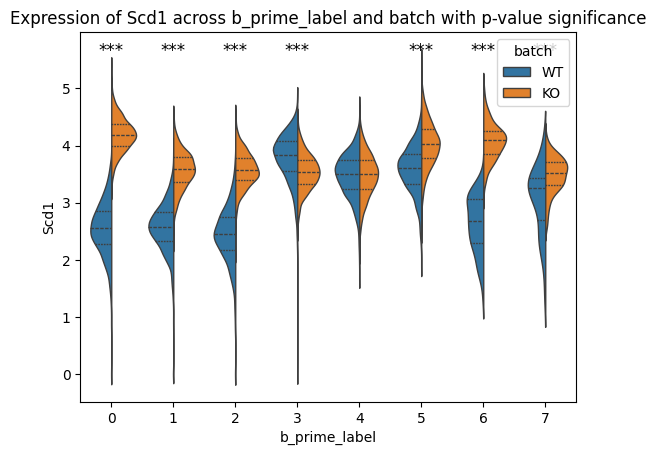

In [107]:
filtered_df = df[df["b_prime_label"] != "8"]
batch_groups = filtered_df.groupby('batch')['Scd1'].apply(list)

# 执行 Kruskal-Wallis H 检验
stat, p_value = stats.kruskal(*batch_groups)

# 绘制小提琴图
sns.violinplot(data=filtered_df, x='b_prime_label', y='Scd1', hue="batch",
               split=True, inner="quart", linewidth=1,order=["0", "1", "2", "3", "4", "5", "6", "7"])
# 计算每个 b_prime_label 中不同 batch 之间的 Kruskal-Wallis H 检验 p 值
unique_b_prime_labels = filtered_df['b_prime_label'].unique()

# 存储每个 b_prime_label 的 p 值
for b_prime_label in unique_b_prime_labels:
    # 筛选出当前 b_prime_label 的数据
    group_data = filtered_df[filtered_df['b_prime_label'] == b_prime_label]
    
    # 获取当前 b_prime_label 下不同 batch 的数据
    batch_groups = group_data.groupby('batch')['Scd1'].apply(list)
    
    # 执行 Kruskal-Wallis H 检验
    stat, p_value = stats.kruskal(*batch_groups)
    
    # 根据 p 值显示 * 的数量
    if p_value < 0.001:
        p_significance = '***'
    elif p_value < 0.01:
        p_significance = '**'
    elif p_value < 0.05:
        p_significance = '*'
    else:
        p_significance = ''
    
    # 在小提琴图上显示 p 值对应的 * 标记
    plt.text(x=b_prime_label, y=filtered_df['Scd1'].max(), 
             s=p_significance, ha='center', va='bottom', 
             fontsize=12, color='black')

# 显示图表
plt.title('Expression of Scd1 across b_prime_label and batch with p-value significance')
plt.savefig('I:\\mutiomics\\ICC\\combined\\scd1violin_plot_with_p_values.pdf', format='pdf')
plt.show()